# Pairwise Spectral EMD Example

Example code to load in events and calculate their pairwise spectral EMDs. Takes about 15 seconds to compile + 30 seconds to run on my laptop, assuming the dataset is already downloaded (Approx 11000 pairs per minute) uing the default presets in this notebook. The more memory, the merrier.

Before using, make sure to `pip install .` in the root directory of this repository.

In [11]:
from pyspecter.SPECTER import SPECTER

# Utils
from particleloader import load
from particleloader.utils import center_and_normalize_zyphi
from rikabplotlib.plot_utils import newplot, plot_event


# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import time

# Load Dataset

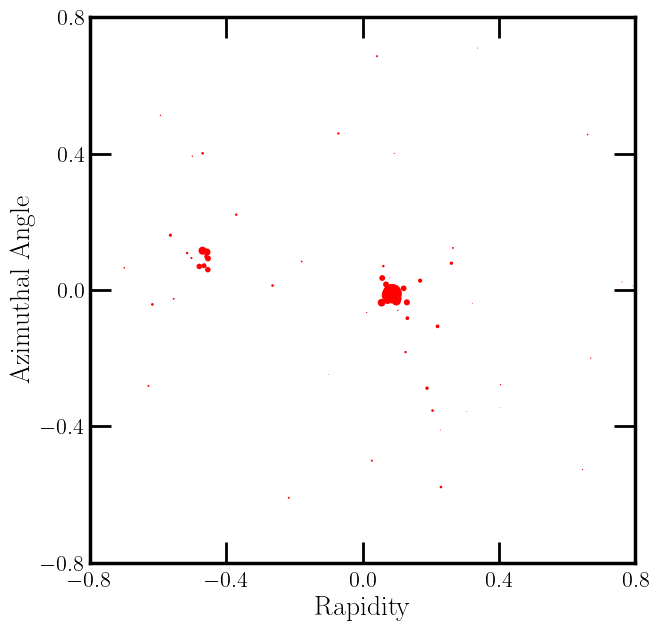

<Axes: xlabel='Rapidity', ylabel='Azimuthal Angle'>

In [15]:
pad = 75 # Note that runtime is pad^2, memory is pad^4
dataset_name = "SPECTER_qcd_jets" # Can also be "SPECTER_top_jets"
cache_dir = "~/.ParticleLoader"

n_samples = 100
batch_size = 250 # Number of pairs to process in parallel, can probably be increased.

# Load data -- this will take a while the first time. Downloads the data from the CMS Open Data portal. Sub in your own data if you have if you want.
data = load(dataset_name, n_samples, cache_dir)
data = center_and_normalize_zyphi(data)[:n_samples, :pad]

# Show an event
fig, ax = newplot("full")
plot_event(ax, data[0], R = 0.8)


# Set up SPECTER

In [13]:
# Set up and compile SPECTER
specter = SPECTER(compile = True)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compiling SPECTER model...
Generating test events for tracing ...
Test events generated! Time taken:  8.413914203643799  seconds.
Compiling spectral representation functions ...
Compiling observables...
Observables compiled! Time taken:  67.16738867759705  seconds.
Compilation complete! Time taken:  67.16741347312927  seconds.


# Compute EMDs
Compute the EMDs between every pair of events, in parallel batches of `batch_size` events.

In [16]:
# Get list of pairwise indices
i_pairs, j_pairs = np.triu_indices(n_samples, k = 1)

# Initialize matrix to store pairwise EMDs
pairwise_emds = np.zeros((n_samples, n_samples))

# Compute batches
start_time = time.time()
for n in range(0, len(i_pairs), batch_size):

    print(f"Computing Batch {n}-{n+batch_size} of {len(i_pairs)} pairs. Elapsed Time: {time.time() - start_time :.3f} seconds")
    i_batch = i_pairs[n : n + batch_size]
    j_batch = j_pairs[n : n + batch_size]
    
    # Compute the pairwise EMDs
    emds = specter.spectralEMD(data[i_batch], data[j_batch])
    
    # Store the results
    pairwise_emds[i_batch, j_batch] = emds
    pairwise_emds[j_batch, i_batch] = emds

print(f"Done! Total Elapsed Time: {time.time() - start_time :.3f} seconds")

Computing Batch 0-250 of 4950 pairs. Elapsed Time: 0.000 seconds
Computing Batch 250-500 of 4950 pairs. Elapsed Time: 6.901 seconds
Computing Batch 500-750 of 4950 pairs. Elapsed Time: 7.976 seconds
Computing Batch 750-1000 of 4950 pairs. Elapsed Time: 9.134 seconds
Computing Batch 1000-1250 of 4950 pairs. Elapsed Time: 10.055 seconds
Computing Batch 1250-1500 of 4950 pairs. Elapsed Time: 11.014 seconds
Computing Batch 1500-1750 of 4950 pairs. Elapsed Time: 12.158 seconds
Computing Batch 1750-2000 of 4950 pairs. Elapsed Time: 13.156 seconds
Computing Batch 2000-2250 of 4950 pairs. Elapsed Time: 14.015 seconds
Computing Batch 2250-2500 of 4950 pairs. Elapsed Time: 15.236 seconds
Computing Batch 2500-2750 of 4950 pairs. Elapsed Time: 16.361 seconds
Computing Batch 2750-3000 of 4950 pairs. Elapsed Time: 17.502 seconds
Computing Batch 3000-3250 of 4950 pairs. Elapsed Time: 18.447 seconds
Computing Batch 3250-3500 of 4950 pairs. Elapsed Time: 19.336 seconds
Computing Batch 3500-3750 of 4950

Text(0, 0.5, 'Density')

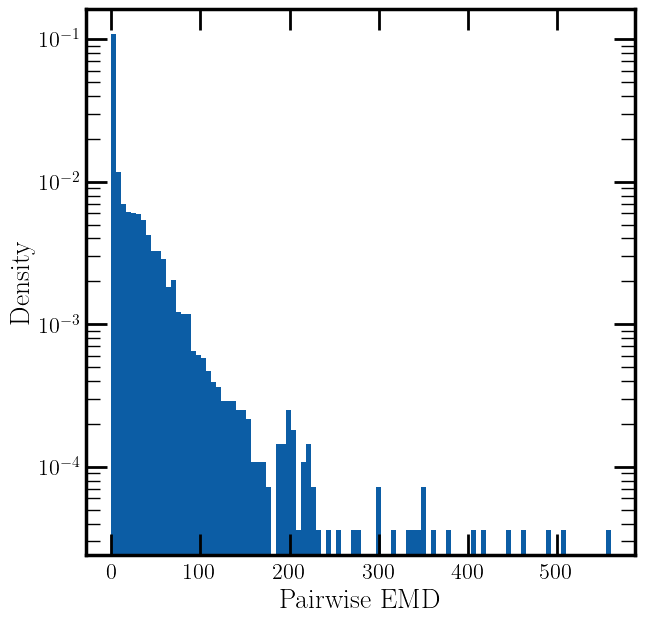

In [17]:
# Histogram the results (upper triangle only)
fig, ax = newplot("full")
plt.hist(pairwise_emds[np.triu_indices(n_samples, k = 1)], bins = 100, density=True)
plt.yscale("log")
plt.xlabel("Pairwise EMD")
plt.ylabel("Density")
